In [ ]:
# source env/bin/activate
# python -m ipykernel install --user --name=env --display-name="Python (myenv)"



: 

In [1]:
import speech_recognition as sr
import os
import cv2
import pyaudio
import wave
import threading
import numpy as np
import time
import matplotlib.pyplot as plt
from deepface import DeepFace

2023-11-14 21:08:34.724778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Directory  /Users/miao /.deepface created
Directory  /Users/miao /.deepface/weights created


In [2]:
def capture_audio(duration, filepath):
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100

    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)

    frames = []

    for _ in range(0, int(RATE / CHUNK * duration)):
        data = stream.read(CHUNK)
        frames.append(data)

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(filepath, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

def capture_video(duration, filepath):
    cap = cv2.VideoCapture(0)
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Using 'mp4v' codec
    out = cv2.VideoWriter(filepath, fourcc, 20.0, (1280, 720), True)

    start_time = time.time()
    while int(time.time() - start_time) < duration:
        ret, frame = cap.read()
        if ret:
            out.write(frame)
        else:
            break

    cap.release()
    out.release()

def capture_audio_video(duration, video_path="output.avi", audio_path="output.mp4"):
    audio_thread = threading.Thread(target=capture_audio, args=(duration, audio_path))
    video_thread = threading.Thread(target=capture_video, args=(duration, video_path))

    audio_thread.start()
    video_thread.start()

    audio_thread.join()
    video_thread.join()

video_path = "./data_capture/video.mp4"
audio_path = "./data_capture/audio.wav"
capture_audio_video(5, video_path, audio_path)

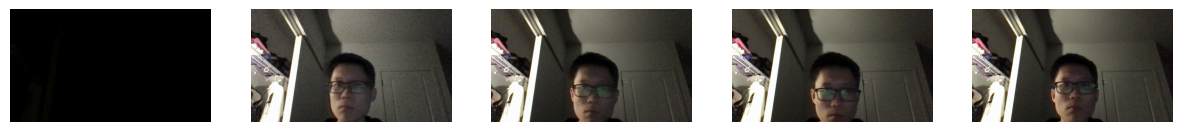

In [3]:
def extract_frames(video_path, num_frames=10):
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames_to_extract = np.linspace(0, total_frames - 1, num=num_frames, dtype=int)

    extracted_frames = []

    for frame_num in frames_to_extract:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if ret:
            extracted_frames.append(frame)

    cap.release()
    return extracted_frames

def display_frames(frames):
    plt.figure(figsize=(15, 10))
    for i, frame in enumerate(frames):
        plt.subplot(1, len(frames), i + 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()
    
frames = extract_frames(video_path, num_frames=5)

# Deepface API img_path might need to be a relative path in the repo
# Consider save frame as an actual file if this does not work.
resp = DeepFace.analyze(img_path = frames, 
        actions = ['emotion']
)

display_frames(frames)

In [10]:
def transcribe_audio(wav_file):
    recognizer = sr.Recognizer()
    with sr.AudioFile(wav_file) as source:
        audio_data = recognizer.record(source)
        try:
            text = recognizer.recognize_google(audio_data)
            return text
        except sr.UnknownValueError:
            return "Google Speech Recognition could not understand audio"
        except sr.RequestError as e:
            return f"Could not request results from Google Speech Recognition service; {e}"

def wav_to_text(wav_file):
    text = transcribe_audio(wav_file)
    return text

wav_to_text("./data/test.wav")

result2:
{   'alternative': [   {   'confidence': 0.92534178,
                           'transcript': 'the stale smell of old beer lingers '
                                         'it takes heat to bring out the odor '
                                         'a cold dip restores health and zest '
                                         'a salt pickle taste fine with ham '
                                         'tacos al pastor are my favorite a '
                                         'zestful food is the hot cross bun'},
                       {   'confidence': 0.92534178,
                           'transcript': 'the stale smell of old beer lingers '
                                         'it takes heat to bring out the odor '
                                         'a cold dip restores health and zest '
                                         'a salt pickle tastes fine with ham '
                                         'tacos al pastor are my favorite a '
             

'the stale smell of old beer lingers it takes heat to bring out the odor a cold dip restores health and zest a salt pickle taste fine with ham tacos al pastor are my favorite a zestful food is the hot cross bun'

In [3]:
def text_to_speech_mac(text):
    os.system(f'say "{text}"')

text_to_speech_mac("Hello, this is a test of the macOS text-to-speech utility.")
